<a href="https://colab.research.google.com/github/dragssvd/UN_Image_Inpainting_Project/blob/main/ENC_DEC_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [109]:
!pip install comet-ml

In [110]:
import comet_ml

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import einops
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

## CometML

In [111]:
import os

from google.colab import userdata
key = userdata.get('COMET_API_KEY')
os.environ['COMET_API_KEY'] = key

## Pick device

In [112]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set default tensor type for cuda
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        # Ensure we're using float32 on CPU
        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

Using cuda device


# Dataset

In [113]:
!pip install datasets

In [114]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("Artificio/WikiArt_Full").with_format("torch")

In [115]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 103250
    })
})

In [116]:
# 90% train, 10% test + validation
train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']}).with_format("torch")

ds = train_test_valid_dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 82600
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
    valid: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
})


In [117]:
# # Extract 10% of the train set
# ten_percent_train = ds["train"].select(range(int(len(ds["train"]) * 0.1)))

# # Extract 10% of the test set
# ten_percent_test = ds["test"].select(range(int(len(ds["test"]) * 0.1)))

# # Extract 10% of the validation set
# ten_percent_valid = ds["valid"].select(range(int(len(ds["valid"]) * 0.1)))

# # Combine the subsets into a new DatasetDict
# ten_percent_dataset = DatasetDict({
#     "train": ten_percent_train,
#     "test": ten_percent_test,
#     "valid": ten_percent_valid
# })

# ds = ten_percent_dataset
# # for testing

In [118]:
# ds["test"]["image"][42]

In [119]:
# ds["test"]["style"][42]

In [120]:
# # Assuming 'ds' is your DatasetDict
# image = ds["test"]["image"][42]
# # Convert PIL.Image.Image to NumPy array
# image_np = np.array(image)
# # Transpose the dimensions
# plt.imshow(image_np.transpose(1, 2, 0))
# plt.show()

## Dataloader


In [121]:
  # change if not colab
  num_workers = 2
  pin_memory = True

  train_loader = DataLoader(
      ds["train"],
      batch_size=32,
      num_workers=num_workers,
      shuffle=True,
      pin_memory=True,
  )

  test_loader = DataLoader(
      ds["test"],
      batch_size=32,
      num_workers=num_workers,
      shuffle=False,
      pin_memory=True,
  )

  val_loader = DataLoader(
      ds["test"],
      batch_size=32,
      num_workers=num_workers,
      shuffle=False,
      pin_memory=True,
  )

# Autoencoder


## **Encoders**

### Basic encoder

In [122]:
import torch
import torch.nn as nn
import einops

class Encoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_size),
            nn.ReLU(),
        )

    def __init__(self, latent_width: int = 2048, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        self.model = nn.Sequential(
            Encoder.conv_block(3, 64),   # [32, 8, 128, 128]
            Encoder.conv_block(64, 128),   # [32, 8, 64, 64]
            Encoder.conv_block(128, 256),  # [32, 16, 32, 32]
            Encoder.conv_block(256, 512), # [32, 16, 16, 16]
            Encoder.conv_block(512, 512), # [32, 16, 8, 8]
            Encoder.conv_block(512, 512), # [32, 16, 4, 4]
        )

        # Adjust Linear layer input to match 16 * 2 * 2
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, self.latent_width),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)  # Convolutional layers
        x = einops.rearrange(x, "b c w h -> b (c w h)")  # Flatten for Linear
        x = self.fc(x)  # Fully connected layers
        return x

### Variance Encoder

In [123]:
class VarianceEncoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_size),
            nn.LeakyReLU(),
        )

    def __init__(self, latent_width: int = 2048, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        self.model = nn.Sequential(
            Encoder.conv_block(3, 64),   # [32, 8, 128, 128]
            Encoder.conv_block(64, 128),   # [32, 8, 64, 64]
            Encoder.conv_block(128, 256),  # [32, 16, 32, 32]
            Encoder.conv_block(256, 512), # [32, 16, 16, 16]
            Encoder.conv_block(512, 512), # [32, 16, 8, 8]
            Encoder.conv_block(512, 512), # [32, 16, 4, 4]
        )

        self.fc_mu = nn.Linear(512 * 4 * 4, self.latent_width)
        self.fc_logvar = nn.Linear(512 * 4 * 4, self.latent_width)

    def reparametrize(self, mean: torch.Tensor, logvariance: torch.Tensor):
        # transform N(0,1) into N(mean, variance)
        std_dev = torch.exp(0.5 * logvariance)
        eps = torch.randn_like(std_dev)
        return eps * std_dev + mean

    def encode(self, x: torch.Tensor):
        x = self.model(x)
        x = einops.rearrange(x, "b c w h -> b (c w h)")
        mean = self.fc_mu(x)
        logvariance = self.fc_logvar(x)
        return mean, logvariance

    def forward(self, x: torch.Tensor):
        mean, logvariance = self.encode(x)
        z = self.reparametrize(mean, logvariance)
        return z, mean, logvariance

### Loss function for variance encoder

In [124]:
def kld_loss_func(mean, logvariance):
    # distance from normal distribution

    # commonly seen version:
    # return torch.mean(
    #     -0.5 * torch.sum(1 + logvariance - mean**2 - logvariance.exp(), dim=1),
    #     dim=0,
    # )

    loss = einops.reduce(
        1 + logvariance - mean**2 - torch.exp(logvariance),
        "batch latent -> batch",
        "sum",
    )
    return einops.reduce(-0.5 * loss, "batch -> ()", "mean")


## Decoder

In [125]:
import torch
import torch.nn as nn
import einops

class Decoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_size,
                out_size,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,  # Ensures alignment of dimensions
            ),
            nn.BatchNorm2d(out_size),
            nn.ReLU(),
        )

    def __init__(self, latent_width: int = 2048, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        # Fully connected layer to project latent vector into feature map
        self.fc = nn.Sequential(
            nn.Linear(self.latent_width, 512 * 4 * 4),
            nn.ReLU(),
        )

        # Transposed convolutions to upsample
        self.model = nn.Sequential(
            Decoder.conv_block(512, 512), # [32, 16, 8, 8]
            Decoder.conv_block(512, 512), # [32, 16, 4, 4]
            Decoder.conv_block(512, 256), # [32, 16, 16, 16]
            Decoder.conv_block(256, 128),  # [32, 16, 32, 32]
            Decoder.conv_block(128, 64),   # [32, 8, 64, 64]
            Decoder.conv_block(64, 3),   # [32, 8, 128, 128]
        )

        # Final activation ensures output in [0, 1] range
        self.final_activation = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        # Fully connected layer to expand latent vector
        x = self.fc(x)
        x = einops.rearrange(x, "b (c w h) -> b c w h", c=512, w=4, h=4)

        # Transposed convolutions to reconstruct image
        x = self.model(x)

        # Final activation for output normalization
        x = self.final_activation(x)
        return x

## Autoencoder

In [126]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images: torch.Tensor):
        latent = self.encoder(images)
        decoded = self.decoder(latent)

        return decoded, latent

# Model setup

In [127]:
# model
latent_width = 2048
encoder = Encoder(latent_width)
decoder = Decoder(encoder.latent_width)
model = Autoencoder(encoder, decoder)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (4): Sequential(
        (0): Conv2

## Comet_ML setup logger

In [128]:
!pip install torchinfo
!pip install torchmetrics

In [129]:
# logging

from torch.utils.data import DataLoader  # NOQA
from datasets import load_dataset  # NOQA

from torchinfo import summary  # NOQA

from tqdm import tqdm  # NOQA

from comet_ml.integration.pytorch import log_model  # NOQA

from torchmetrics.functional.image import structural_similarity_index_measure  # NOQA

comet_experiment = comet_ml.Experiment(
    project_name="UczenieNienadzorowane")
comet_experiment.log_code(folder="/UN")
comet_experiment.log_parameters(
    {
        "batch_size": train_loader.batch_size,
        "train_size": ds["train"].num_rows,
        "val_size": ds["test"].num_rows,
    }
)

summ = summary(model, (1, 3, 256, 256), device=device, depth=5)
comet_experiment.set_model_graph(f"{model.__repr__()}\n{summ}")


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : deliberate_nation_2638
COMET INFO:     url                   : https://www.comet.com/dragssvd/uczenienienadzorowane/c184d547eced43b39e2c4c2658d86211
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_SSIM [33]      : (0.288798451423645, 0.41410067677497864)
COMET INFO:     test_loss [33]      : (0.15732167661190033, 0.2187933623790741)
COMET INFO:     train_SSIM [1295]   : (0.05618112534284592, 0.4392213821411133)
COMET INFO:     train_loss [1295]   : (0.16048195958137512, 0.27242904901504517)
COMET INFO:     validate_SSIM [165] : (0.

# Train autoencoder

In [130]:
# pure PyTorch loop
num_epochs = 5
# loss_func = F.mse_loss
loss_func = F.l1_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [131]:
comet_experiment.log_parameter("num_epochs", num_epochs)
comet_experiment.log_parameter("loss_func", loss_func.__name__)

comet_experiment.add_tag(f"LOSS: {loss_func.__name__}")


In [132]:
# train and validate
for epoch in range(num_epochs):
        comet_experiment.set_epoch(epoch)

        model.eval()
        with comet_experiment.validate() as validat, torch.no_grad() as nograd:
            for idx, batch in tqdm(enumerate(val_loader), desc=f"VAL_{epoch}"):
                comet_experiment.set_step(idx + epoch * len(val_loader))

                images = batch["image"] / 255.0
                # labels = batch["label"]
                images = images.to(device)
                predictions, latents = model(images)
                loss = loss_func(predictions, images)

                metric = structural_similarity_index_measure(
                    predictions, images)

                comet_experiment.log_metric("loss", loss.item())
                comet_experiment.log_metric("SSIM", metric.item())

                # if idx < 4:
                #     images = einops.rearrange(
                #         [images, predictions],
                #         "source batch 1 height width -> batch height (source width)",
                #     ).cpu()
                #     comet_experiment.log_image(
                #         images[0], f"images_{idx}", step=epoch)

        model.train()
        with comet_experiment.train() as train:
            for idx, batch in tqdm(enumerate(train_loader), desc=f"TRAIN_{epoch}"):
                comet_experiment.set_step(idx + epoch * len(train_loader))

                # look at: model.encoder.parameters().__next__()
                # look at: model.encoder.parameters().__next__().grad
                # look at: latents.shape

                optimizer.zero_grad()  # MUST be called on every batch
                images = batch["image"] / 255.0
                labels = batch["style"]
                images = images.cuda()
                predictions, latents = model(images)
                loss = loss_func(predictions, images)
                loss.backward()
                optimizer.step()

                metric = structural_similarity_index_measure(
                    predictions, images)

                comet_experiment.log_metric("loss", loss.item())
                comet_experiment.log_metric("SSIM", metric.item())

                if not idx % 50:
                    comet_experiment.log_histogram_3d(
                        latents.detach().cpu(), "latents")

VAL_0: 323it [00:38,  8.33it/s]
TRAIN_0: 2582it [09:58,  4.32it/s]
VAL_1: 323it [00:32,  9.82it/s]
TRAIN_1: 2582it [09:56,  4.33it/s]
VAL_2: 323it [00:32,  9.98it/s]
TRAIN_2: 2582it [09:57,  4.32it/s]
VAL_3: 323it [00:32,  9.89it/s]
TRAIN_3: 2582it [09:56,  4.33it/s]
VAL_4: 323it [00:32,  9.82it/s]
TRAIN_4: 2582it [09:57,  4.32it/s]


In [133]:
import torchvision.transforms as T
model.eval()
with comet_experiment.test() as test, torch.no_grad():
    for idx, batch in tqdm(enumerate(test_loader), desc=f"TEST_{num_epochs}"):
        comet_experiment.set_step(idx + num_epochs * len(test_loader))

        images = batch["image"] / 255.0
        labels = batch["style"]
        images = images.cuda()

        # Model predictions and latents
        predictions, latents = model(images)

        # Compute loss
        loss = loss_func(predictions, images)

        # Compute SSIM metric
        metric = structural_similarity_index_measure(predictions, images)

        # Log metrics
        comet_experiment.log_metric("loss", loss.item())
        comet_experiment.log_metric("SSIM", metric.item())

        if idx < 4:
          try:
              # Rearrange tensors to HWC (Height-Width-Channel) format
              images = einops.rearrange(
                  images, "batch channel width height -> batch width height channel"
              ).cpu().detach().numpy()

              predictions = einops.rearrange(
                  predictions, "batch channel width height -> batch width height channel"
              ).cpu().detach().numpy()

              # Ensure pixel values are in range [0, 1] and convert to uint8
              images = np.clip(images, 0, 1)
              predictions = np.clip(predictions, 0, 1)

              images = (images * 255).astype(np.uint8)
              predictions = (predictions * 255).astype(np.uint8)

              # Log the first image in the batch as an example
              combined_image = np.hstack((images[0], predictions[0]))  # Side-by-side
              comet_experiment.log_image(combined_image, name=f"comparison_{idx}", step=num_epochs)

          except Exception as e:
              print(f"Error during image logging: {e}")
              print(f"Tensor shape: {images.shape if 'images' in locals() else 'N/A'}")

TEST_5: 323it [00:32,  9.80it/s]


TEST_5: 0it [00:00, ?it/s]

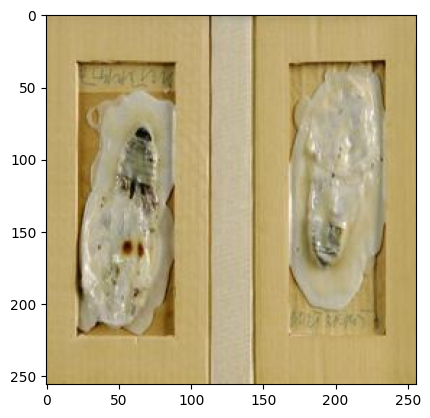

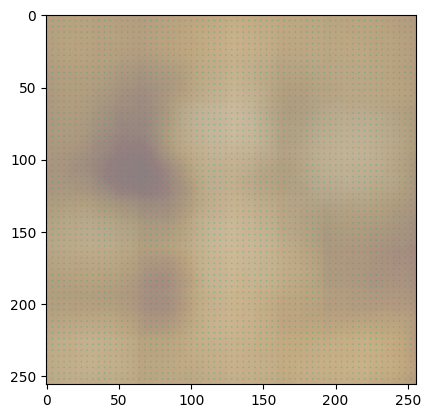

TEST_5: 1it [00:00,  1.10it/s]

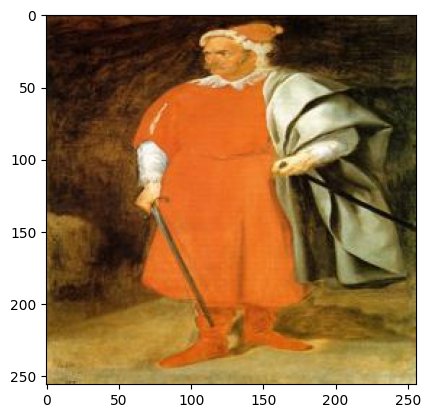

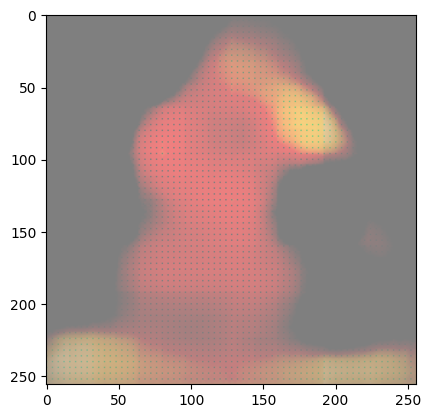

TEST_5: 2it [00:01,  1.23it/s]

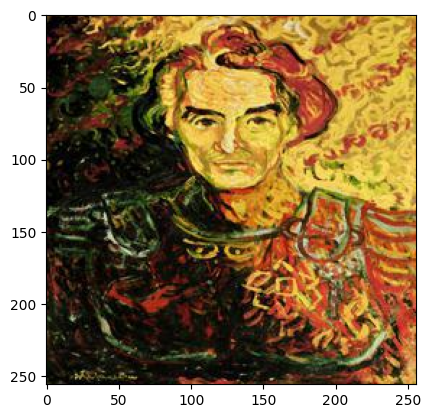

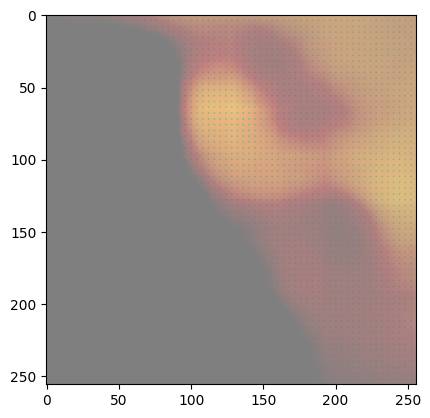

TEST_5: 3it [00:02,  1.23it/s]

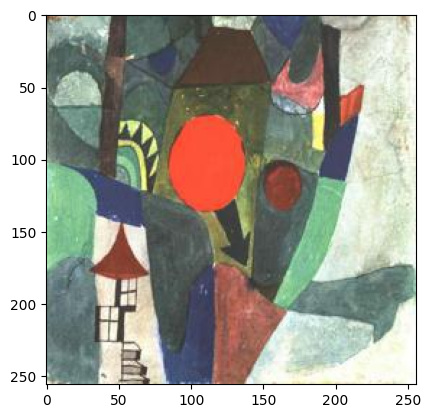

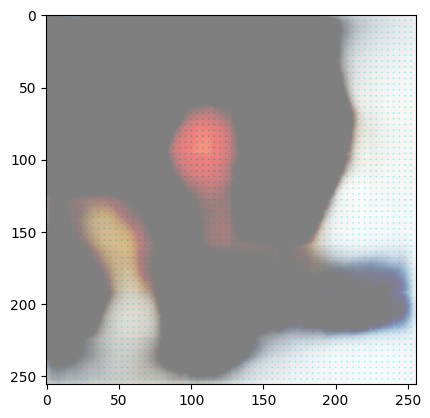

TEST_5: 4it [00:03,  1.27it/s]

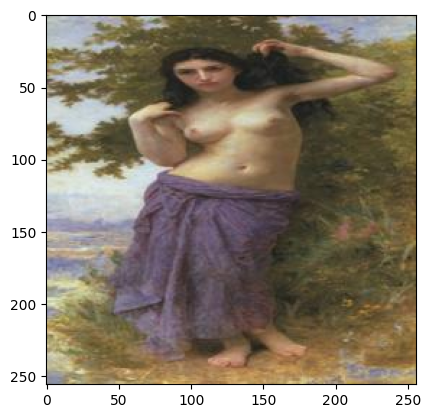

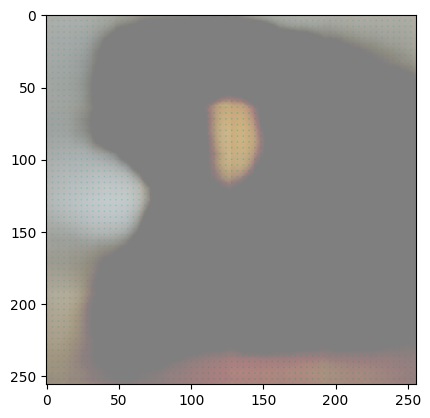

TEST_5: 5it [00:04,  1.26it/s]

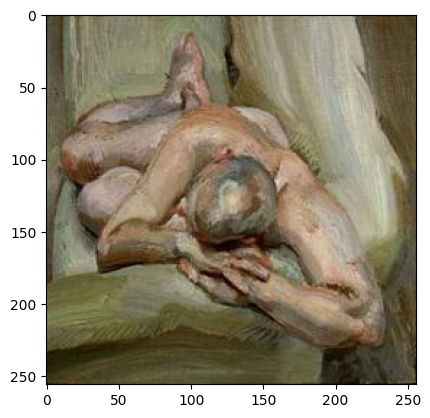

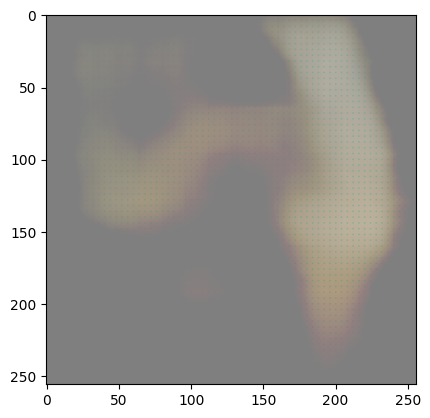

TEST_5: 6it [00:04,  1.26it/s]

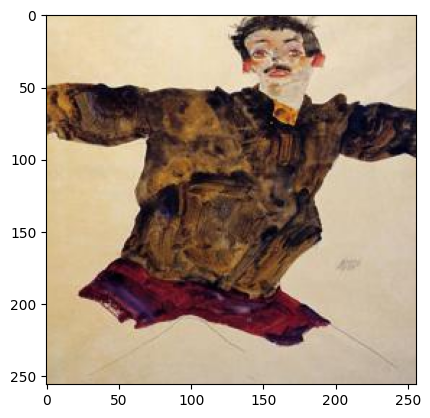

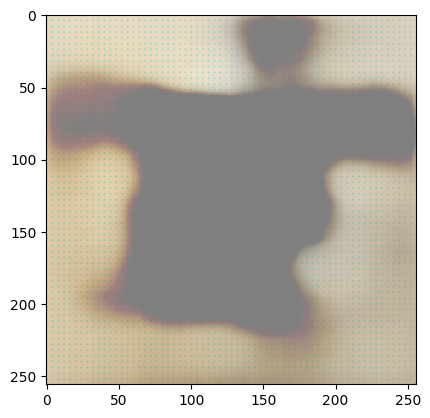

TEST_5: 7it [00:05,  1.28it/s]

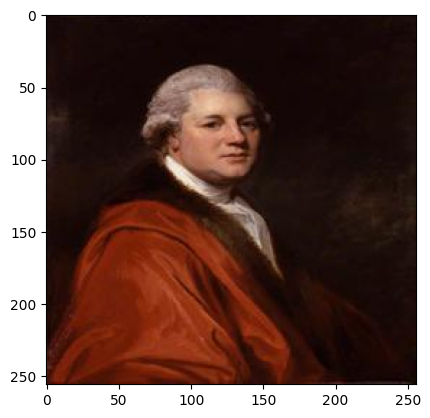

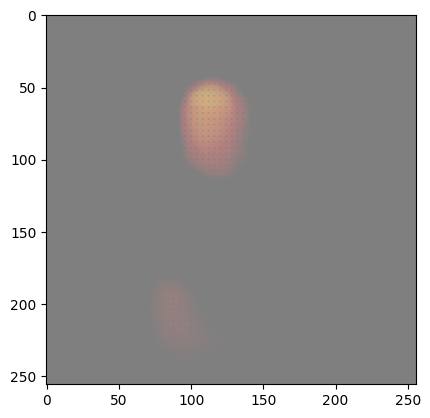

TEST_5: 8it [00:06,  1.42it/s]

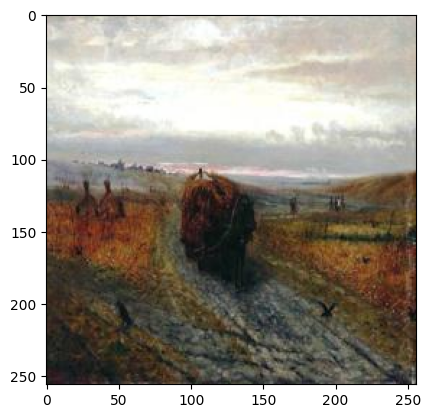

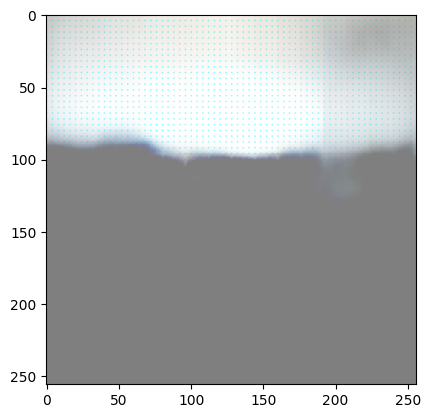

TEST_5: 9it [00:06,  1.50it/s]

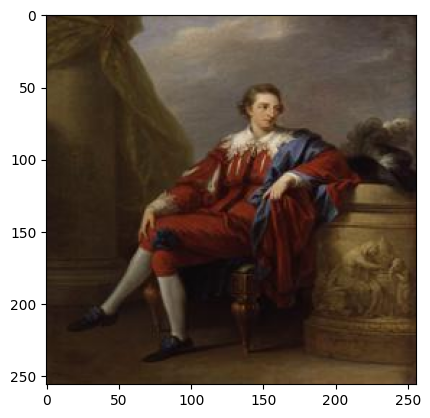

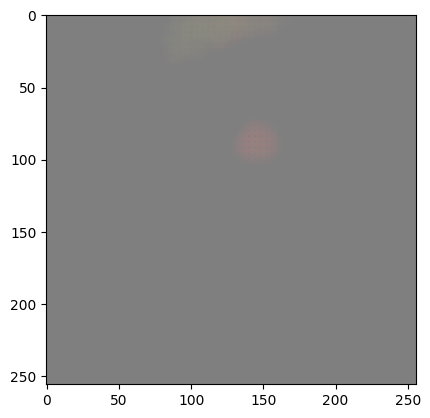

TEST_5: 10it [00:07,  1.61it/s]

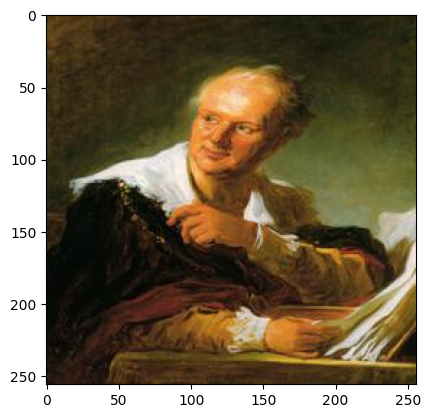

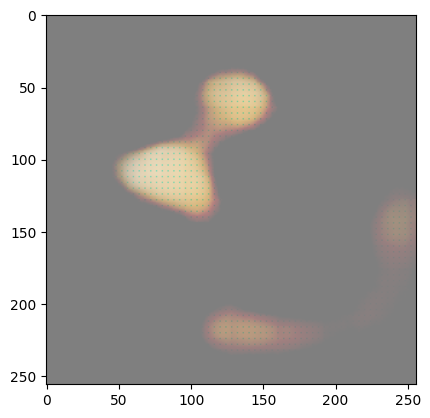

TEST_5: 10it [00:07,  1.29it/s]


In [134]:
for idx, batch in tqdm(enumerate(test_loader), desc=f"TEST_{num_epochs}"):
  images = batch["image"] / 255.0
  labels = batch["style"]
  images = images.cuda()

  # Model predictions and latents
  predictions, latents = model(images)

  images = (images * 255).byte()
  predictions = (predictions * 255).byte()

  # Convert PIL.Image.Image to NumPy array
  image_np = np.array(images[0].to('cpu'))
  # Transpose the dimensions
  plt.imshow(image_np.transpose(1, 2, 0))
  plt.show()

    # Convert PIL.Image.Image to NumPy array
  image_np = np.array(predictions[0].to('cpu'))
  # Transpose the dimensions
  plt.imshow(image_np.transpose(1, 2, 0))
  plt.show()

  if idx == 10:
    break


In [135]:
# Log model
log_model(comet_experiment, model, model_name="AutoEncoder")